In [12]:
import numpy as np
import matplotlib.pyplot as plt
import corner
import emcee

In [77]:
N_likelihoods = 100
data_dimension = 10

In [78]:
#define weights w
w = 1/abs(np.random.randn(N_likelihoods))

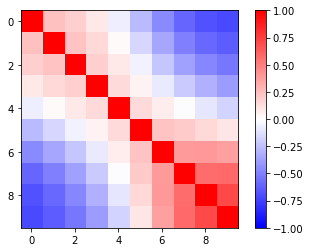

In [79]:
#define unitary covariance matrices
x = np.linspace(0, 1, data_dimension)
cov = np.eye(len(x))
C0 = 1
for i in range(data_dimension):
    for j in range(data_dimension):
        cov[i,j] = C0*np.exp(-(x[i]-x[j])**2)
        cov[i,i] = np.exp(np.exp(-(x[i])))
plt.imshow(np.corrcoef(cov), cmap = 'bwr', vmin=-1, vmax= 1)
plt.colorbar()

In [142]:
coeff_var = np.random.random(N_likelihoods)*(2-.1)+.1

In [143]:
#define model
x = np.linspace(0, 1, data_dimension)
def model(a, b, c):
    return c * np.exp(-(a * x ** 2 + b * x))

In [144]:
atrue= 1
btrue = 1
ctrue = 10
data0 = model(atrue, btrue, ctrue) 

<ErrorbarContainer object of 3 artists>

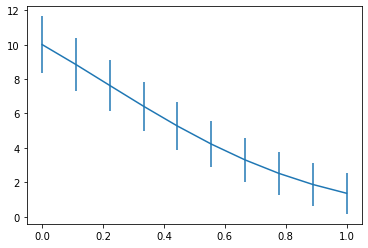

In [145]:
plt.errorbar(x, data0, cov.diagonal()**.5)

In [149]:
inv_cov = np.linalg.inv(cov)
det_cov = np.linalg.det(cov)
def log_likelihood_composite(p):
    a, b, c = p
    mod = model(a, b, c)
    res = []
    for i in range(N_likelihoods):
        Li = np.exp(-.5*np.sum((data0-mod)*inv_cov.dot((data0-mod))/coeff_var[i]))/(((2*np.pi)**data_dimension*coeff_var[i]**data_dimension*det_cov)**.5)
        res.append(Li)
    return np.sum(np.log(res*w))

In [150]:
log_likelihood_composite([1,1,1])

-4525.198701990205

In [151]:
initial= [atrue+1, btrue,ctrue]
npath = 200
ndim = 3
nwalkers =50
pos = initial + 0.01 * np.random.randn(nwalkers, len(initial))
sampler = emcee.EnsembleSampler(nwalkers, ndim,log_likelihood_composite,)
sampler.run_mcmc(pos ,npath, progress=True)
samplers = sampler.get_chain(discard = 0, flat = True)

100%|██████████| 200/200 [00:17<00:00, 11.64it/s]


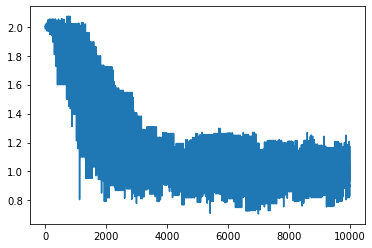

In [152]:
plt.plot(samplers[:,0])

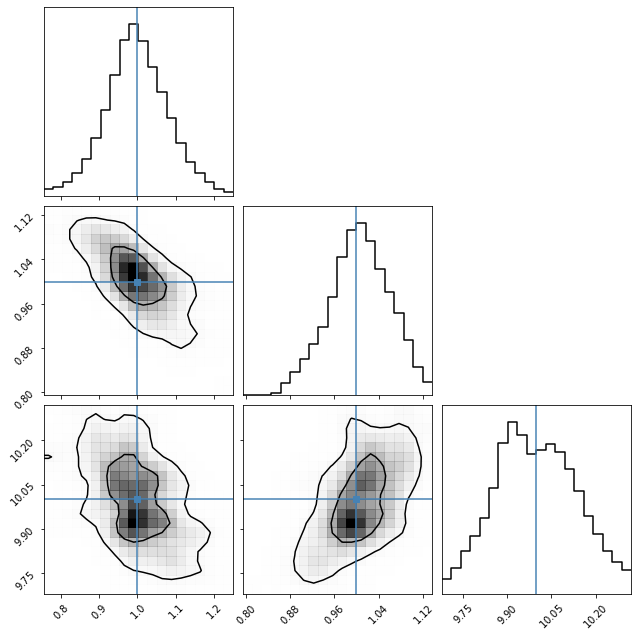

In [153]:
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
c = ['r', 'b', 'g','m']
fig, ax = plt.subplots(3,3, figsize=(10,10))
fig=corner.corner(samplers[9000:], fig = fig,bins=20, color = 'k',
plot_datapoints=False,
    smooth1d=True,smooth=True, levels=[sigma1, sigma2],
    fill_contours=False, label_kwargs={"fontsize": 20},#hist_kwargs={'density':True},
    group='posterior',  truths=[atrue, btrue, ctrue] ,
    use_math_text=True,)